# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [2]:
variables = ['pr']
variable = 'pr'
variable_obs = 'pr'
TITLE = 'Precipitation'
ylabel = '$E_{pr}$ ($mm/day$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [6]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

# Get data : obs, PPE, p1

In [7]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/'
filename = 'pr_mon_mean_197901-201912_regrid.nc'

In [8]:
path = path_observation
variables = [variable_obs]
df_obs = load_monthly_clim(path, filename, variables)
df_obs

pr
month lat        lon                
1     -88.927735 0.00000    0.023976
                 1.40625    0.026398
                 2.81250    0.026663
                 4.21875    0.028602
                 5.62500    0.028689
...                              ...
12     88.927735 352.96875  0.397433
                 354.37500  0.384588
                 355.78125  0.384481
                 357.18750  0.382383
                 358.59375  0.382303

[393216 rows x 1 columns]

In [9]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.3159773 0.3089214 ... 0.50588834 0.50602216

In [10]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_pr_xarr(path, filename, variables)

In [11]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_pr_xarr(path, filename, variables)
    i=i+1

In [12]:
amip['p1'] = p1_amip

# Calcule full RMSE (ej)

In [13]:
# Reference p1
diff = (amip['p1'].values - obs[variable_obs].values)**2
diff_p1 = sqrt(sum(diff)/(128*256))
diff_p1

1.110857503511521

In [14]:
ej = {}
#ej['p1'] = diff_p1

for p in nb_p_list :
    diff_tmp = (amip[p] - obs[variable_obs])**2
    diff = sqrt(diff_tmp.sum(dim=['lat', 'lon'])/(128*256))
    ej[p] = diff


### Save

In [15]:
np.save(path_files+'npy/CNRMppe_decomposition_ej_'+str(variable)+'.npy', ej)

# EOF + truncated RMSE (rj)

## EOF

In [26]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [27]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [28]:
# Mean wheigted with cos(lat) : 
lats = matrix['lat'][:]
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat).drop(labels='height').values
W =wgts[np.newaxis,:,np.newaxis]
#W

In [29]:
# Compute anomalies by removing the ensemble-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean

In [30]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom, center=False)

In [31]:
eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(npcs=100, pcscaling=0)

In [32]:
varFrac = solver.varianceFraction(neigs=100)

### Save

In [24]:
for i in range(0,len(eof),1) : 
    j = i+1
    # EOFmap
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    EOF_df.to_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy")
    
    #EOFpc
    pc_p1 = pc[0, i]
    pc_mb = pc[1:, i]
    np.save(path_files+'npy/CNRMppe_decomposition_p1_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_p1)
    np.save(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_mb)

In [25]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df.to_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy')

## Get the observations

In [16]:
Mean =  pd.read_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
X_obs = obs[variable_obs] - Mean
#X_obs = obs.expand_dims(dim={'dummy':range(0,102,1)})
#X_obs = obs.fillna(0.0)
X_obs

<xarray.DataArray (lat: 128, lon: 256)>
array([[ 0.15481789,  0.14776198,  0.14733894, ...,  0.15847398,
         0.15743346,  0.15736948],
       [ 0.1752205 ,  0.16955374,  0.16811289, ...,  0.18180187,
         0.18269391,  0.18092386],
       [ 0.06653311,  0.06409507,  0.06472389, ...,  0.05535324,
         0.07242978,  0.0693799 ],
       ...,
       [-0.21180651, -0.2125687 , -0.20906597, ..., -0.15390069,
        -0.21105871, -0.21069551],
       [-0.14553684, -0.14512193, -0.14187002, ..., -0.14788821,
        -0.14652043, -0.14568334],
       [-0.04341273, -0.04204671, -0.04197257, ..., -0.04905604,
        -0.04689728, -0.04676347]])
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'prmean'

In [17]:
def Error_rj(cpt, U_obs, variable):
    rj_list = []
    for i in range(0,len(U_obs),1) :
        j=i+1
        pc = np.load(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(variable)+'.npy')
        diff = (pc[cpt]-U_obs[i])**2
        rj_list.append(diff)
        #print(pc[cpt])
        #print(U_obs[i])
        #print(diff)
    rj_E = sqrt(sum(rj_list)/(128*256))
    return rj_E

## Emulation

In [18]:
def MultiLinReg(limit_train, EOF_nb, x, variable) :
    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_files+'npy/CNRMppe_decomposition_EOF'+str(EOF_nb)+'pc_'+str(variable)+'.npy')
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]
  
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [19]:
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
pc_OS={}
pc={}


def predict_OS(X, EOF_nb) :
    tmp_list = []
    for x in X[80:] :
        tmp = MultiLinReg(80, EOF_nb, x, variable)
        tmp_list.append(tmp)
    return tmp_list

def predict_train(X, EOF_nb) :
    tmp_list = []
    for x in X[:80] :
        tmp = MultiLinReg(80, EOF_nb, x, variable)
        tmp_list.append(tmp)
    return tmp_list
    
for i in range(1,101,1) : 
    pc_OS['modes_'+str(i)] = predict_OS(X, i)
    pc['modes_'+str(i)] = predict_train(X,i)

#pc_pred

In [20]:
df_pc_OS = pd.DataFrame(pc_OS['modes_1'], columns=['modes_1'])
df_pc = pd.DataFrame(pc['modes_1'], columns=['modes_1'])
for i in range(1,101,1) :
    df_pc_OS['modes_'+str(i)] = pc_OS['modes_'+str(i)]
    df_pc['modes_'+str(i)] = pc['modes_'+str(i)]

In [21]:
def Error_rj_pred(df_pc_pred, U_obs, variable, p):
    rj_pred_list = []
    for i in range(0,len(U_obs),1) :
        j=i+1
        pc_pred = df_pc_pred['modes_'+str(i+1)] 
        diff = (pc_pred[p]-U_obs[i])**2
        rj_pred_list.append(diff)
        
    rj_pred = sqrt(sum(rj_pred_list)/(128*256))
    return rj_pred

# 4, 10 and 100 modes considered

In [22]:
ej_list = []
for p in nb_p_list :
    ej_tmp = ej[p]
    ej_list.append(ej_tmp)

In [53]:
neofs = 100
U_obs = solver.projectField(X_obs, neofs=neofs, weighted=False, eofscaling=0)
#U_obs = U_obs[0:4]
U_obs

<xarray.DataArray 'pseudo_pcs' (mode: 100)>
array([117.63038248, -70.87011941,  -2.50984539,  43.17187017,
       -71.60775019,  30.22033051, -31.33634037,  37.68519852,
        -3.44639572,  18.94772083, -35.15003208,  29.73606773,
        -1.62857778,  12.79788922,  13.98123091,  -9.81864081,
       -10.65963967, -25.88836189, -12.91380807, -28.9063873 ,
         2.36631298,  -4.83723958, -14.82819198,  -2.32876657,
        -7.0380442 ,  -7.67003876,   6.1855741 ,   3.31431175,
        -0.6171696 ,  -4.40046708,   2.61921687,  -7.99379162,
        20.61544618,  -3.91971522,  10.3823384 ,   6.0169876 ,
         9.81545757,   9.37233416,  -5.81797963,   6.2553809 ,
        -8.63082762,  -5.65296979,   7.12768106,  11.2866394 ,
        -5.98432854,  17.03928227,  -4.08454996,  -7.84431957,
         1.41426163,  -1.32740041,  10.33543537,  10.58550925,
         4.50215544,   3.21759534,  -1.61924843,   8.62712013,
         2.64057656,  -2.04292209,  14.07041392,  -9.01505129,
        -2.69057452,   3.88899247,  -7.09024834,  12.74467184,
        -3.06393984,  -0.73676349,  -3.47042992,   4.31086825,
       -12.01235327,   0.96657122,  -6.8422716 ,  -6.15236386,
       -11.21724157,  -0.31493166,   6.33049136,   2.70869198,
         5.56105282,   5.02611702,  -1.34800361,   0.81853371,
         5.13730079,  -4.02117511,  -1.61538094,   6.7977692 ,
        -2.52157892,   4.12047565,  -9.69682312,   5.13001929,
        -2.53090708,   3.8534806 ,   3.80840266,  -7.38135961,
         1.92000862,   8.80687271,   3.39290776,  -0.3020976 ,
        -1.20939242,   1.71066374,   5.34395128,   2.65596958])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:  None_pseudo_pcs

In [54]:
df_fig = pd.DataFrame(ej_list, columns=['ej'])
df_fig_pred = pd.DataFrame(ej_list[:80], columns=['ej'])
df_fig_pred_OS = pd.DataFrame(ej_list[80:], columns=['ej'])

  
rj_list=[]
cpt=0
for p in nb_p_list:
    tmp = Error_rj(cpt, U_obs, variable)
    rj_list.append(tmp)
    cpt+=1
        
df_fig['rj'] = rj_list
df_fig['frac'] = abs(df_fig['rj']-df_fig['ej'])   
        
rj_pred_OS_list = []
for p in range(0,22,1) : 
    tmp = Error_rj_pred(df_pc_OS, U_obs, variable, p)
    rj_pred_OS_list.append(tmp)   
    
df_fig_pred_OS['rj_pred'] = rj_pred_OS_list

rj_pred_list = []
for p in range(0,80,1) : 
    tmp = Error_rj_pred(df_pc, U_obs, variable, p)
    rj_pred_list.append(tmp)   
    
df_fig_pred['rj_pred'] = rj_pred_list

In [55]:
rj_list = []
for i in range(0,len(U_obs),1) :
    j=i+1
    pc = np.load(path_files+'npy/CNRMppe_decomposition_p1_EOF'+str(j)+'pc_'+str(variable)+'.npy')
    diff = (U_obs[i]-pc)**2
    rj_list.append(diff)
p1_rj = sqrt(sum(rj_list)/(128*256))#/10
p1_rj

0.8754958858620793

In [56]:
#p1_vec={}
#p1_vec['ej'] = diff_p1
#p1_vec['rj'] = p1_rj
p1_vec = []
p1_vec.append(diff_p1)
p1_vec.append(p1_rj)
p1_vec

[1.110857503511521, 0.8754958858620793]

In [57]:
Unresolved = abs(p1_rj-diff_p1)#*diff_p1
Unresolved

0.23536161764944163

In [58]:
df_fig['test'] = df_fig['rj'] + Unresolved
df_fig_pred['test'] = df_fig_pred['rj_pred'] + Unresolved
df_fig_pred_OS['test'] = df_fig_pred_OS['rj_pred'] + Unresolved

In [59]:
p1_vec[1] = p1_vec[1] + Unresolved

In [60]:
coeff = (df_fig['ej'][90] - df_fig['ej'][5])/(df_fig['test'][90] - df_fig['test'][5])
line_tmp = df_fig['test']*coeff
intercept = df_fig['ej'].mean() - line_tmp.mean()
line = range(0,6,1)*coeff 
line = line + intercept

# Figure

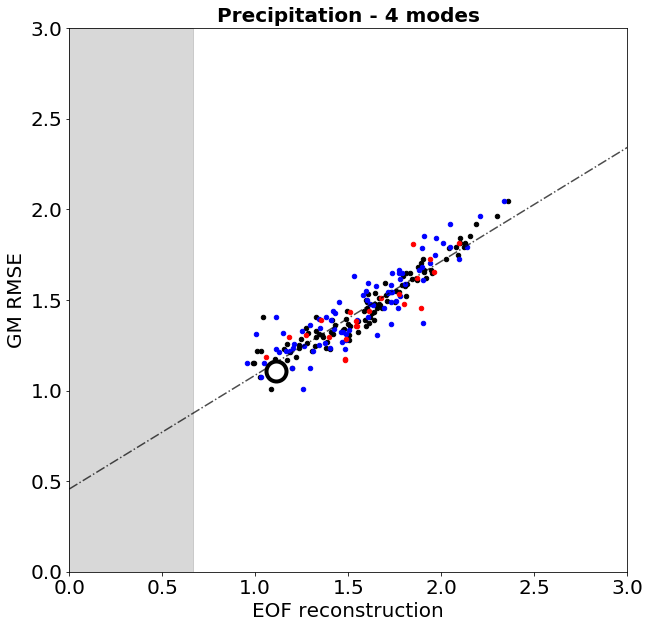

In [43]:
plt.figure(figsize=(10, 10))
    

ax = plt.gca()
#ax2 = ax.twinx()


ax.axvspan(0, Unresolved, alpha=0.3, color='gray')
ax.plot(range(0,6,1), line, linestyle="-.", alpha=0.7,  color='black')
# ------- PLOT p1 sur la figure : work in progress --------
ax.plot(p1_vec[1], p1_vec[0], marker='o', color='white', markeredgecolor='black', markeredgewidth=4, 
        markersize=20)
#---------------------------
df_fig.plot(kind='scatter', x='test', y='ej', color = 'black', alpha=1, ax=ax)
df_fig_pred.plot(kind='scatter', x='test', y='ej', color = 'blue', alpha=1, ax=ax)
df_fig_pred_OS.plot(kind='scatter', x='test', y='ej', color = 'red', alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('EOF reconstruction', size = 20)
ax.set_ylabel('GM RMSE', size = 20)
ax.set_title('Precipitation - '+str(neofs)+' modes', fontsize=20, 
             fontweight = 'bold')
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

plt.xlim([0, 3])
plt.ylim([0, 3])

# Legend .................

#legend = [ 'Correlation', 'Unresolved fraction']
#ax.get_legend().remove()
#ax.legend(legend, fontsize=25, bbox_to_anchor=(1.65, 0.83)) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Fig3_"+variable+"_"+str(neofs)+"modes.png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

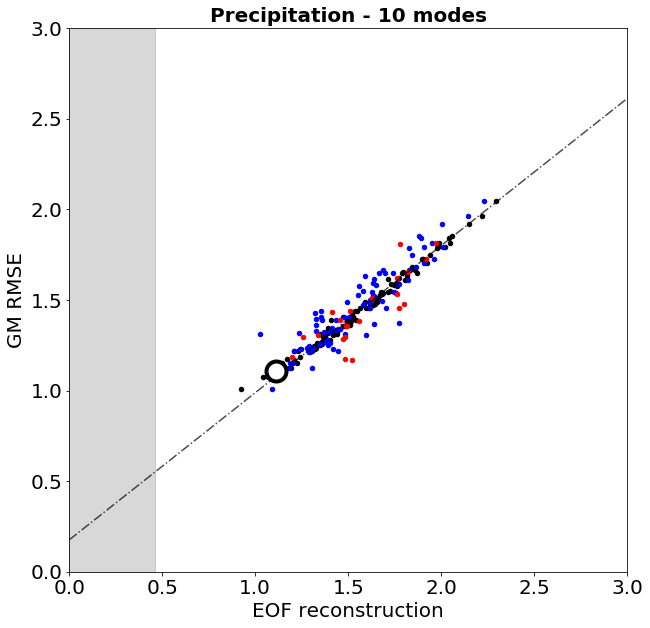

In [52]:
plt.figure(figsize=(10, 10))
    

ax = plt.gca()
#ax2 = ax.twinx()


ax.axvspan(0, Unresolved, alpha=0.3, color='gray')
ax.plot(range(0,6,1), line, linestyle="-.", alpha=0.7,  color='black')
# ------- PLOT p1 sur la figure : work in progress --------
ax.plot(p1_vec[1], p1_vec[0], marker='o', color='white', markeredgecolor='black', markeredgewidth=4, 
        markersize=20)
#---------------------------
df_fig.plot(kind='scatter', x='test', y='ej', color = 'black', alpha=1, ax=ax)
df_fig_pred.plot(kind='scatter', x='test', y='ej', color = 'blue', alpha=1, ax=ax)
df_fig_pred_OS.plot(kind='scatter', x='test', y='ej', color = 'red', alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('EOF reconstruction', size = 20)
ax.set_ylabel('GM RMSE', size = 20)
ax.set_title('Precipitation - '+str(neofs)+' modes', fontsize=20, 
             fontweight = 'bold')
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

plt.xlim([0, 3])
plt.ylim([0, 3])

# Legend .................

#legend = [ 'Correlation', 'Unresolved fraction']
#ax.get_legend().remove()
#ax.legend(legend, fontsize=25, bbox_to_anchor=(1.65, 0.83)) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Fig3_"+variable+"_"+str(neofs)+"modes.png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

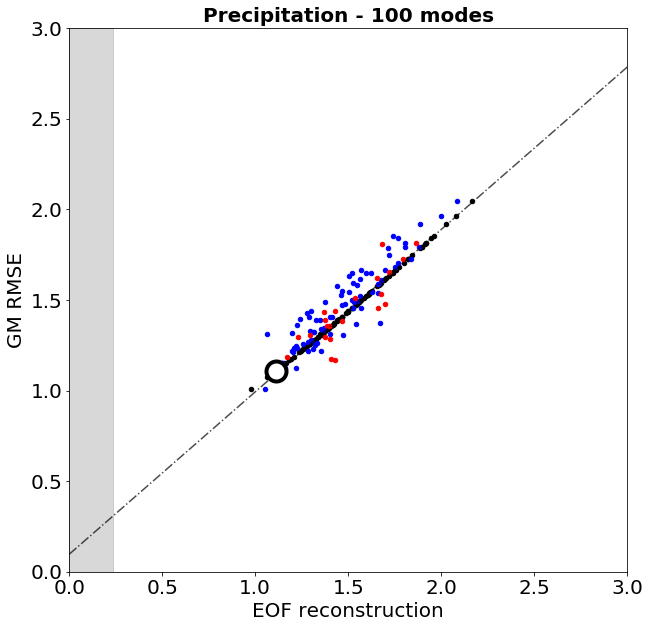

In [61]:
plt.figure(figsize=(10, 10))
    

ax = plt.gca()
#ax2 = ax.twinx()


ax.axvspan(0, Unresolved, alpha=0.3, color='gray')
ax.plot(range(0,6,1), line, linestyle="-.", alpha=0.7,  color='black')
# ------- PLOT p1 sur la figure : work in progress --------
ax.plot(p1_vec[1], p1_vec[0], marker='o', color='white', markeredgecolor='black', markeredgewidth=4, 
        markersize=20)
#---------------------------
df_fig.plot(kind='scatter', x='test', y='ej', color = 'black', alpha=1, ax=ax)
df_fig_pred.plot(kind='scatter', x='test', y='ej', color = 'blue', alpha=1, ax=ax)
df_fig_pred_OS.plot(kind='scatter', x='test', y='ej', color = 'red', alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('EOF reconstruction', size = 20)
ax.set_ylabel('GM RMSE', size = 20)
ax.set_title('Precipitation - '+str(neofs)+' modes', fontsize=20, 
             fontweight = 'bold')
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

plt.xlim([0, 3])
plt.ylim([0, 3])

# Legend .................

#legend = [ 'Correlation', 'Unresolved fraction']
#ax.get_legend().remove()
#ax.legend(legend, fontsize=25, bbox_to_anchor=(1.65, 0.83)) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Fig3_"+variable+"_"+str(neofs)+"modes.png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()